In [1]:
!pip3 install pandas

In [2]:
# Read In Data
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


goalies_df = pd.read_csv('/content/drive/My Drive/Goalies.csv', on_bad_lines="skip")
teams_df = pd.read_csv('/content/drive/My Drive/Teams.csv')

Mounted at /content/drive


In [3]:
# Merge datasets
merged_df = pd.merge(
    teams_df,
    goalies_df,
    on=['year', 'tmID'],
    how='inner'
)

# 1. Drop unnecessary columns
columns_to_drop = ['lgID_y', 'confID', 'divID', 'franchID', 'name',
                  'PostGP', 'PostMin', 'PostW', 'PostL', 'PostT', 'PostENG',
                  'PostSHO', 'PostGA', 'PostSA', 'playoff', 'rank', 'ENG',
                  'lgID_x', 'GA_y', 'W_x', 'L_x', 'T', 'OTL', 'W_y', 'L_y',
                  'T/OL', 'SoW', 'SoL']
cleaned_df = merged_df.drop(columns=columns_to_drop)

# 2. Rename columns for clarity
cleaned_df = cleaned_df.rename(columns={'GA_x': 'GA'})

# 3. Group by team and year to get team-level statistics
team_stats = cleaned_df.groupby(['year', 'tmID']).agg({
    'G': 'first',          # Games played by team
    'Pts': 'first',        # Team points
    'GF': 'first',         # Goals for
    'GA': 'first',         # Goals against
    'GP': 'sum',           # Total games played by goalies
    'Min': 'sum',          # Total minutes by goalies
    'SHO': 'sum',          # Total shutouts
    'SA': 'sum',           # Total shots against
    'PIM': 'first',        # Penalties in minutes
    'PPG': 'first',        # Power play goals
    'PPC': 'first',        # Power play chances
    'PKG': 'first',        # Penalty kill goals against
    'PKC': 'first'         # Penalty kill chances
}).reset_index()

# 4. Calculate additional metrics
team_stats['SavePercentage'] = (team_stats['SA'] - team_stats['GA']) / team_stats['SA']
team_stats['GoalsAgainstAvg'] = (team_stats['GA'] * 60) / team_stats['Min']

# 5. Handle missing/infinite values
team_stats = team_stats.replace([np.inf, -np.inf], np.nan)

# 6. Display summary statistics and check for missing values
print("\nDataset Shape:", team_stats.shape)
print("\nMissing Values:")
print(team_stats.isnull().sum())
print("\nSummary Statistics:")
print(team_stats.describe())

# Prepare features and target
features_to_drop = ['Pts', 'year', 'tmID']
X = team_stats.drop(columns=features_to_drop)
y = team_stats['Pts']

# Clean NaN and infinite values before modeling
print(f"\nOriginal number of rows: {len(X)}")

# 1. Remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan)
mask = ~X.isna().any(axis=1)  # Create mask of rows without NaN
X = X[mask]
y = y[mask]

print(f"Number of rows after removing NaN/infinite values: {len(X)}")
print(f"Removed {len(team_stats) - len(X)} rows")


Dataset Shape: (1519, 17)

Missing Values:
year                 0
tmID                 0
G                    0
Pts                  0
GF                   0
GA                   0
GP                   0
Min                  0
SHO                  0
SA                   0
PIM                110
PPG                418
PPC                419
PKG                418
PKC                419
SavePercentage     685
GoalsAgainstAvg      0
dtype: int64

Summary Statistics:
              year            G          Pts           GF           GA  \
count  1519.000000  1519.000000  1519.000000  1519.000000  1519.000000   
mean   1974.527979    69.518104    71.276498   218.764977   218.764977   
std      28.708711    19.699843    26.277603    77.905094    79.168426   
min    1909.000000     1.000000     0.000000     4.000000     8.000000   
25%    1957.000000    70.000000    54.000000   176.000000   173.500000   
50%    1981.000000    80.000000    75.000000   227.000000   228.000000   
75%    1998.0

Query execution time: 0.004 seconds
Number of Rows: 1519
Number of Columns: 3
    tmID   PPG   GF
795  EDM  81.0  446
837  EDM  78.0  426


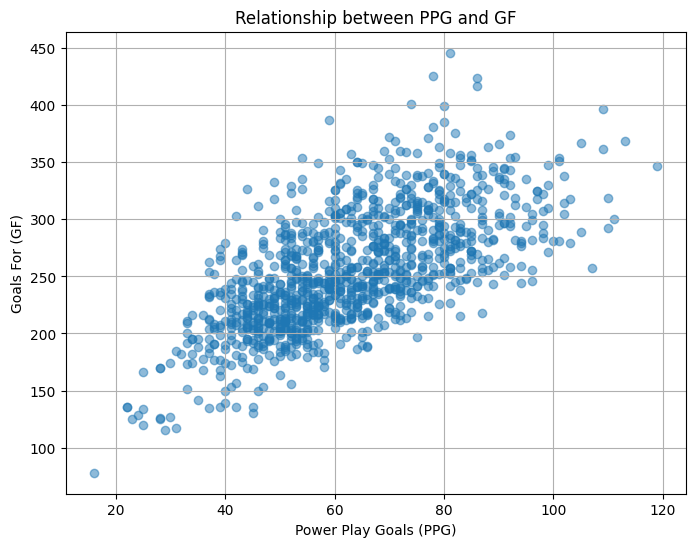

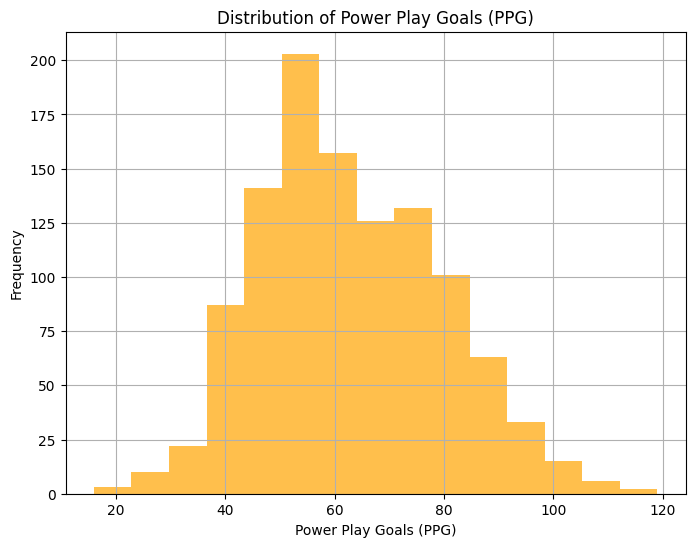

In [4]:
import matplotlib.pyplot as plt
import time

start_time = time.time()
team_stats_wade = team_stats[['tmID', 'PPG', 'GF']].sort_values(by='GF', ascending=False)
end_time = time.time()
print(f"Query execution time: {end_time - start_time:.3f} seconds")
# Count Rows
print(f"Number of Rows: {len(team_stats_wade)}")
print(f"Number of Columns: {len(team_stats_wade.columns)}")

print(team_stats_wade.head(2))

# First visualization: Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(team_stats_wade['PPG'], team_stats_wade['GF'], alpha=0.5)
# Customize the plot
plt.xlabel("Power Play Goals (PPG)")
plt.ylabel("Goals For (GF)")
plt.title("Relationship between PPG and GF")
plt.grid(True)
# Show the plot
plt.show()

# Second Visualization: Histogram of Power Play Goals (PPG)
plt.figure(figsize=(8, 6))
plt.hist(team_stats_wade['PPG'], bins=15, alpha=0.7, color='orange')
# Customize the plot
plt.xlabel("Power Play Goals (PPG)")
plt.ylabel("Frequency")
plt.title("Distribution of Power Play Goals (PPG)")
plt.grid(True)
# Show the plot
plt.show()